In [2]:
# import modules
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt


api = KaggleApi()
api.authenticate()

In [3]:
# download the data

kaggle_data_name = 'mirichoi0218/insurance'

def kaggle_load_data():
    data_kaggle = api.dataset_download_files('mirichoi0218/insurance')
    zf = ZipFile('archive.zip')
    zf = ZipFile('insurance.zip')
    zf.extractall()
    zf.close()
    data = pd.read_csv('insurance.csv')
    return data

loaded_data = kaggle_load_data()

In [4]:
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
loaded_data['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [6]:
loaded_data['children'].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

In [7]:
loaded_data.describe().round()

,age,bmi,children,charges
count,1338.0,1338.0,1338.0,1338.0
mean,39.0,31.0,1.0,13270.0
std,14.0,6.0,1.0,12110.0
min,18.0,16.0,0.0,1122.0
25%,27.0,26.0,0.0,4740.0
50%,39.0,30.0,1.0,9382.0
75%,51.0,35.0,2.0,16640.0
max,64.0,53.0,5.0,63770.0


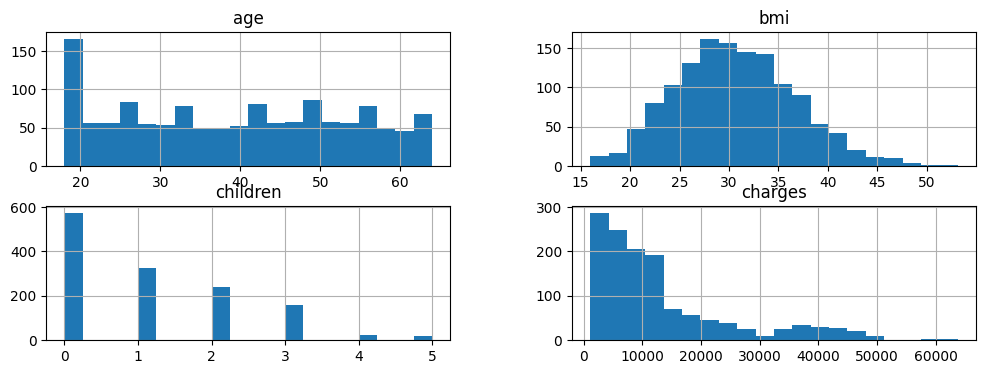

In [8]:
loaded_data.hist(bins=20,figsize=(12, 4))
plt.show()

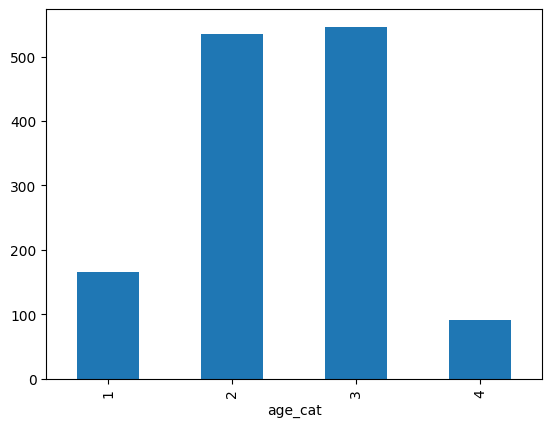

In [9]:
# split data

# we saw that train and test set needs to be stratify because cataegory are not equal

loaded_data['bmi_cat'] = pd.cut(loaded_data['bmi'], bins=[0,20,30,40], labels=[1,2,3])
loaded_data['age_cat'] = pd.cut(loaded_data['age'], bins=[0,20,40,60,80], labels=[1,2,3,4])

loaded_data['age_cat'].value_counts().sort_index().plot.bar()
plt.show()

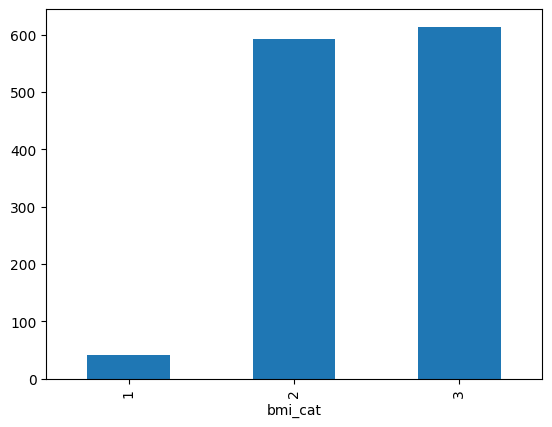

In [10]:
loaded_data['bmi_cat'].value_counts().sort_index().plot.bar()
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

stratify_train_set, stratify_test_set = train_test_split(loaded_data,test_size=0.2,stratify=loaded_data['age_cat'], random_state=42)
print(len(stratify_train_set))
print(len(stratify_test_set))

1070
268


In [12]:
for set_ in (stratify_train_set, stratify_test_set):
 set_.drop(['bmi_cat','age_cat'], axis=1, inplace=True)

In [13]:
stratify_train_set.head()

,age,sex,bmi,children,smoker,region,charges
1106,49,female,29.925,0,no,northwest,8988.15875
1180,42,female,41.325,1,no,northeast,7650.77375
1240,52,male,41.800,2,yes,southeast,47269.85400
1234,45,female,27.830,2,no,southeast,8515.75870
345,34,female,29.260,3,no,southeast,6184.29940


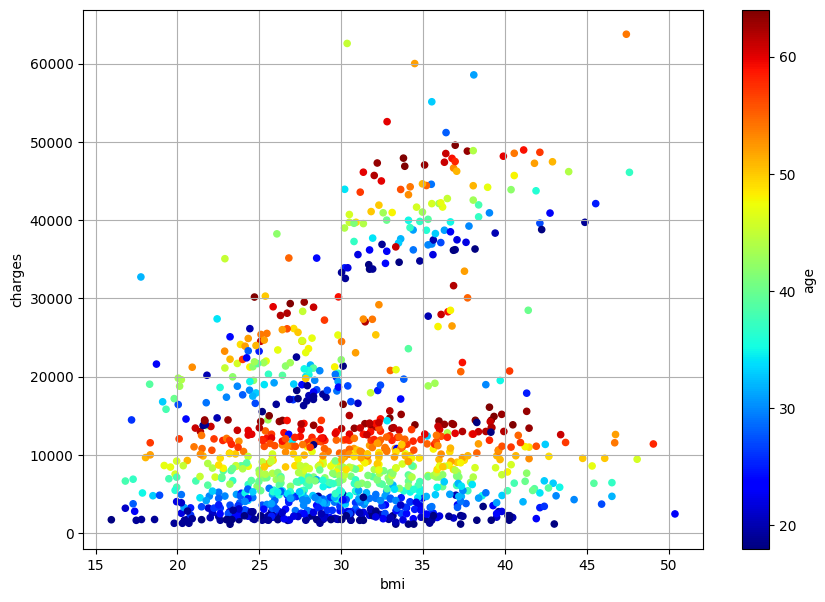

In [14]:
data = stratify_train_set.copy()

data['sex'] = data['sex'].replace('female', 0)
data['sex'] = data['sex'].replace('male', 1)
data['smoker'] = data['sex'].replace('yes', 1)
data['smoker'] = data['sex'].replace('no', 0)


data.plot(kind='scatter', x='bmi', y='charges', grid=True,c='age', cmap='jet', colorbar=True, figsize=(10,7))
plt.show()

In [15]:
num_data = data.select_dtypes(include=['int', 'float'])
corr_matrix = num_data.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.301354
bmi         0.221792
children    0.074553
sex         0.053816
smoker      0.053816
Name: charges, dtype: float64

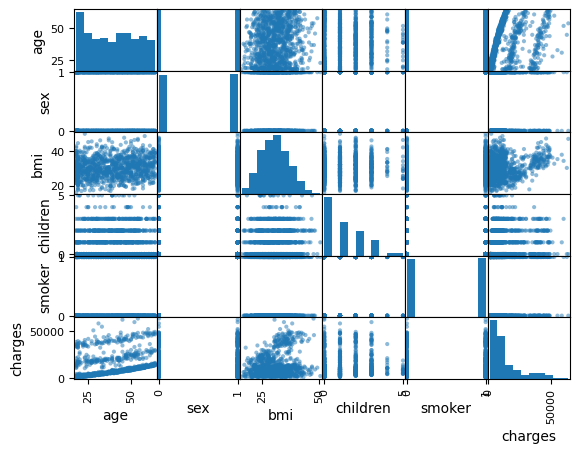

In [16]:
from pandas.plotting import scatter_matrix

scatter_matrix(data)
plt.show()

In [17]:
# prepare data for machine learning

df_values = data.drop('charges', axis=1)
df_target = data['charges'].copy()

# deal with null, na values
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='median')
df_num = df_values.select_dtypes(include=([np.number]))
x = imputer.fit_transform(df_num)
df_transformed = pd.DataFrame(x, columns=df_num.columns, index=df_num.index)

In [18]:
# deal with cat columns

from sklearn.preprocessing import OneHotEncoder

bmi_labels = ['Underweight','Normal weight','Overweight', 'Obese', 'Morbidly obese']
df_values['bmi_cat'] = pd.cut(df_values['bmi'], bins = [0, 18.5, 24.9, 29.9, 40, np.inf], labels = bmi_labels)

cat_encoder = OneHotEncoder()
df_cat = df_values[['bmi_cat']]
df_cat_1hot = cat_encoder.fit_transform(df_cat)
cat_encoder.handle_unknow = 'ignore'
df_cat_1hot_array = df_cat_1hot.toarray()
df_cat_output = pd.DataFrame(df_cat_1hot_array, columns=cat_encoder.get_feature_names_out(), index=df_cat.index)

In [19]:
# same job with pipelines

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())
data_num_prepared = num_pipeline.fit_transform(df_num)

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown="ignore"))
data_cat_prepared = cat_pipeline.fit_transform(df_cat)

from sklearn.compose import make_column_transformer, make_column_selector

preprocessing = make_column_transformer((num_pipeline,make_column_selector(dtype_include=np.number)),(cat_pipeline, make_column_selector(dtype_include=object)))
df_values_prepared = preprocessing.fit_transform(df_values)

In [20]:
# select and train the model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(df_values, df_target)

df_pred = lin_reg.predict(df_values)

print(df_pred[:5].round())
print(df_target.iloc[:5].values.round())

[14072. 18052. 21616. 14128. 12608.]
[ 8988.  7651. 47270.  8516.  6184.]


In [21]:
lin_rmse = mean_squared_error(df_pred, df_target, squared=False)
lin_rmse.round()

11250.0

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(df_values, df_target)
df_pred = tree_reg.predict(df_values)
tree_rmse = mean_squared_error(df_target, df_pred, squared=False)
tree_rmse.round()

270.0

In [23]:
# model confirmation

from sklearn.model_selection import cross_val_score

tree_rmses = - cross_val_score(tree_reg, df_values, df_target, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     16307.307596
std       1331.996282
min      14353.346666
25%      15425.904291
50%      16002.531402
75%      16968.405334
max      18791.182457
dtype: float64

In [24]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, df_values, df_target, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     12460.762898
std        605.954960
min      11595.986650
25%      12074.616145
50%      12306.508226
75%      12876.499378
max      13524.627266
dtype: float64

In [37]:
# model tuning

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
 ("preprocessing", preprocessing),
 ("random_forest", RandomForestRegressor(random_state=42))])

param_grid = {
    'random_forest__max_depth': [5, 10, None], 
    'random_forest__n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
}

grid_search = GridSearchCV(full_pipeline, param_grid = param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(df_values, df_target)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x17c82bb10>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(st...)),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x17df2c1d0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'random_forest__max_depth': [5, 10, None],
                         'random_forest__n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 15]},
             scoring='neg_root_mean_squared_error')

In [38]:
grid_search.best_params_

{'random_forest__max_depth': 5, 'random_forest__n_estimators': 15}

In [42]:
final_model = grid_search.best_estimator_
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.42, 0.01, 0.43, 0.07, 0.02, 0.02, 0.  , 0.01, 0.02])

In [44]:
sorted(zip(feature_importances, final_model['preprocessing'].get_feature_names_out()), reverse=True)

[(0.42782693295043883, 'pipeline-1__bmi'),
 (0.41902091675846376, 'pipeline-1__age'),
 (0.06517453808855364, 'pipeline-1__children'),
 (0.02328639935561488, 'pipeline-2__region_southwest'),
 (0.019197187385462465, 'pipeline-2__region_northeast'),
 (0.018084550798161552, 'pipeline-1__smoker'),
 (0.013642840618009428, 'pipeline-2__region_southeast'),
 (0.009660141166121764, 'pipeline-1__sex'),
 (0.004106492879173818, 'pipeline-2__region_northwest')]

In [48]:
# evaluate on test set

stratify_test_set['sex'] = stratify_test_set['sex'].replace('female', 0)
stratify_test_set['sex'] = stratify_test_set['sex'].replace('male', 1)
stratify_test_set['smoker'] = stratify_test_set['sex'].replace('yes', 1)
stratify_test_set['smoker'] = stratify_test_set['sex'].replace('no', 0)

X_test = stratify_test_set.drop('charges', axis=1)
y_test = stratify_test_set['charges'].copy()

final_pred = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_pred, squared=False)
final_rmse.round()

11998.0

In [52]:
from scipy import stats
confidence = 0.95
squared_errors = (final_pred - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([10849.31041684, 13046.39476632])